# Progetto SPAM DETECTION:
- Addestrare un classificatore per identificare SPAM
- Individuare i Topic principali tra le email SPAM presenti nel dataset
- Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.
- Estrarre dalle mail NON SPAM le Organizzazioni presenti.

# Analisi esplorativa dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import string
from nltk.corpus import stopwords
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from gensim import corpora
from wordcloud import WordCloud
from PIL import Image
import gensim
from gensim.models.coherencemodel import CoherenceModel
from scipy import spatial
import gensim.downloader
from collections import Counter
from typing import List

In [2]:
df = pd.read_csv("spam_dataset.csv", index_col=0)
df.head()

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [3]:
print(df["text"].loc[605]) #esempio di non spam

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


In [4]:
print(df["text"].loc[4685]) #esempio di spam

Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin



In [5]:
df.shape

(5171, 3)

In [6]:
# tengo solo label_num (ham:0, spam:1)
df = df.drop("label", axis=1)

In [7]:
spam_ham_count = df["label_num"].value_counts()
print(spam_ham_count) #non troppo sbilanciata

label_num
0    3672
1    1499
Name: count, dtype: int64


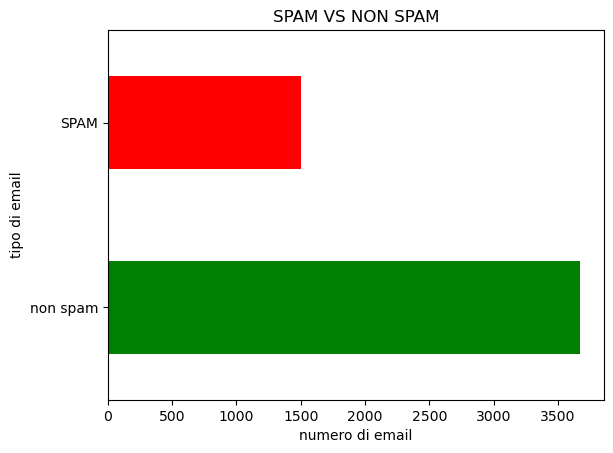

In [8]:
#grafico a barre orizzontali che mostra email spam vs no spam
colors = ["green","red"]
spam_ham_count.plot(kind='barh', title = "spam vs non spam".upper(), color=colors)
plt.xlabel("numero di email")
plt.ylabel("tipo di email")
plt.yticks([0,1], ["non spam","SPAM"])
plt.show()

# Preprocessing: data cleaner

In [9]:
df_clean = df.copy() #uso una copia per eventuali controlli sulle email originali

In [10]:
#data cleaner
english_stopwords = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

# Aggiungo le parole inutili del mio caso specifico
useless_words = ["nbsp", "td td", "td tr", "tr td", "subject", "cc","e mail", "http","email","com","www","etc","fw"]
english_stopwords.extend(useless_words)

def data_cleaner(sentence) -> List[str]:
    """
    Clean a given sentence by applying several transformations.

    This function transforms the input sentence by converting it to lowercase, removing punctuation, 
    lemmatizing words, removing stopwords and single-letter words, and removing numbers.

    Parameters:
    sentence (str): The sentence to clean.

    Returns:
    list: The cleaned sentence as a list of words.
    """
    sentence = sentence.lower() #lowercase
    for c in string.punctuation:
        sentence = sentence.replace(c, ' ') #remove punctuation
    
    document = nlp(sentence)
    sentence = " ".join(token.lemma_ for token in document) #lemmatization
    sentence = " ".join(word for word in sentence.split() if word not in english_stopwords and len(word) > 1) #remove stopwords and single-letter words
    sentence = re.sub('\\d', '', sentence) # remove numbers
    
    return sentence.split()


In [11]:
df_clean["text"] = [' '.join(data_cleaner(document)) for document in df_clean["text"]]

## WordCloud delle parole più frequenti nelle email spam e non spam

In [12]:
# Carico delle immagini come maschere
thumbs_up = np.array(Image.open('up.png'))
thumbs_down = np.array(Image.open('down.png'))

# funzione colore
def color_func(word, font_size, position, orientation, random_state=None, **kwargs) -> str:
    
    """
    Generate a color for a word in a wordcloud based on hue and randomness.

    Parameters:
    word (str): The word to be colored.
    font_size (int): The font size of the word.
    position (tuple): The position of the word in the wordcloud.
    orientation (int): The orientation of the word in the wordcloud.
    random_state (RandomState, optional): A random state for color generation. Defaults to None.
    **kwargs: Additional keyword arguments. In this case, 'hue' can be provided.

    Returns:
    str: A string representing the color of the word in HSL format.
    """
    hue = kwargs.get('hue', 0)
    return f"hsl({hue}, 100%, {int(100.0 * float(random_state.randint(60, 120)) / 255.0)}%)"

#funzione che crea il WordCloud
def create_wordcloud(df, label, hue, mask=None) -> WordCloud:
    
    """
    Generate a wordcloud from a DataFrame of text data.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the text data. It is expected to have a 'label_num' column and a 'text' column.
    label (int): The label number to filter the DataFrame on. Only rows where 'label_num' equals this value will be included in the wordcloud.
    hue (int): The hue to use for the color_func. This will be passed to the color_func function to determine the color of the words.
    mask (numpy.ndarray, optional): An optional mask image to shape the wordcloud. Defaults to None.

    Returns:
    WordCloud: A WordCloud object generated from the frequencies of words in the text data.
    """
    word_freq = Counter()
    for email in df[df['label_num'] == label]['text']:
        word_freq.update(Counter(set(email.split())))
    
    wc = WordCloud(width = 512, height = 512, mask=mask, contour_width=1, contour_color='white', color_func=lambda *args, **kwargs: color_func(*args, **kwargs, hue=hue)).generate_from_frequencies(word_freq)
    
    return wc

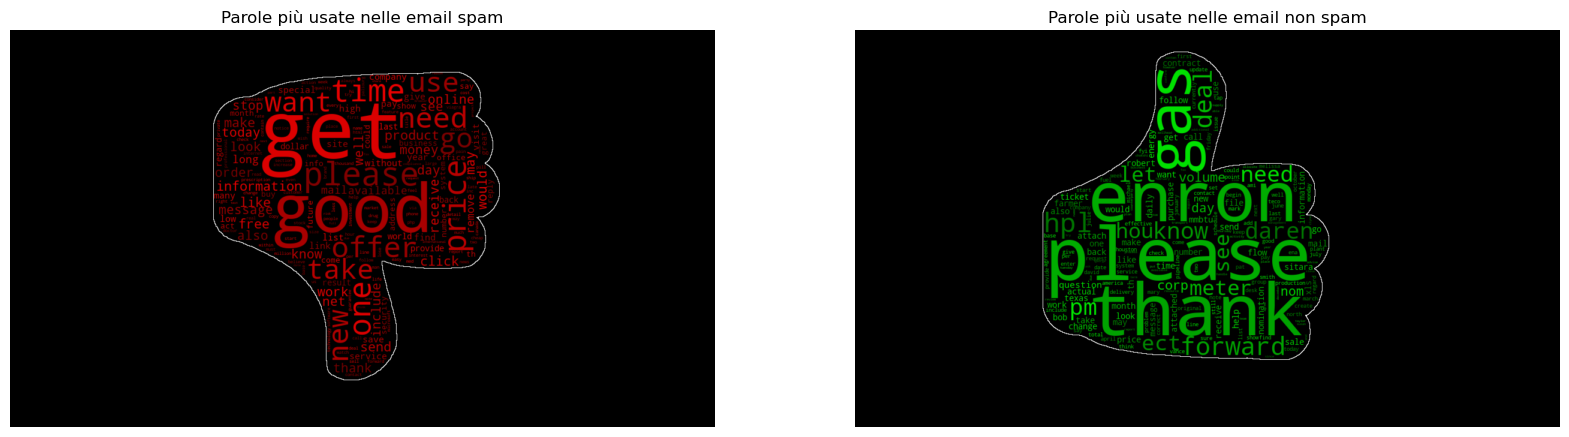

In [13]:
# Genero 2 wordclouds per email spam e non-spam
spam_wc = create_wordcloud(df_clean, 1, 0, mask=thumbs_down) # Tonalità rossa per email spam
non_spam_wc = create_wordcloud(df_clean, 0, 120, mask=thumbs_up) # Tonalità verde per email non-spam

# 2 subplot vicini, per un miglior confronto
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(spam_wc, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Parole più usate nelle email spam')

axs[1].imshow(non_spam_wc, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Parole più usate nelle email non spam')

plt.show()

In [14]:
# Split del dataset in training set e test set
X_train, X_test, y_train, y_test = train_test_split(df_clean["text"], df_clean['label_num'], test_size=0.2, random_state=42)

In [15]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english') #max:80%, min:2 email
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# - Modellazione: classificatore per identificare SPAM

In [16]:
# Addestramento del classificatore
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [17]:
# Valutazione del classificatore
y_pred = svm_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.98      0.99      0.98       293

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035



In [18]:
def preprocess_and_pred(sentence) -> None:

    """
    Preprocess a given sentence using data_cleaner function and print the sentence followed by prediction: SPAM or NO SPAM.

    Parameters:
    sentence (str): The sentence to predict.
    """
    print(sentence)
    sentence = ' '.join(data_cleaner(sentence))
    sentence = tfidf_vectorizer.transform([sentence])
    pred = svm_classifier.predict(sentence)
    print("\n")
    print("CLASSIFICATION RESULT:", " SPAM" if pred==1 else " NO SPAM")
    print("-----------------------------------------")

In [19]:
ex_1 = "Good morning, i need the document signed within 3 days because we need to send it back to the human resources"
ex_2 = "FREE FOR EVERYONE!!!!!! Yes, you hear it right, open this link and you'll find a BIG SURPRISE"
preprocess_and_pred(ex_1)
preprocess_and_pred(ex_2)

Good morning, i need the document signed within 3 days because we need to send it back to the human resources


CLASSIFICATION RESULT:  NO SPAM
-----------------------------------------
FREE FOR EVERYONE!!!!!! Yes, you hear it right, open this link and you'll find a BIG SURPRISE


CLASSIFICATION RESULT:  SPAM
-----------------------------------------


# - Individuare i Topic principali tra le email SPAM presenti nel dataset

In [20]:
spam_emails = df_clean["text"][df_clean['label_num'] == 1]
len(spam_emails)

1499

In [21]:
# Preprocessing delle email
data_words = [email.split() for email in spam_emails]

# Creazione del dizionario
id2word = corpora.Dictionary(data_words)

# Creazione del corpus
corpus = [id2word.doc2bow(text) for text in data_words]

In [22]:
def optimize_lda(dictionary, corpus, texts, start=2, limit=5, step=1, passes_list=[1, 3, 5]) -> gensim.models.LdaMulticore:
    """
    Optimize an LDA model by finding the number of topics and passes that yield the highest coherence value.

    This function iterates over a range of number of topics and a list of passes, 
    creating an LDA model for each combination. 
    It computes the coherence value for each model and keeps track of the model with the highest coherence.

    Parameters:
    dictionary (gensim.corpora.Dictionary): The dictionary of the corpus.
    corpus (list of list of (int, float)): The corpus to be used for the LDA model.
    texts (list of list of str): The texts used to compute the coherence.
    start (int, optional): The starting number of topics. Defaults to 2.
    limit (int, optional): The maximum number of topics. Defaults to 5.
    step (int, optional): The step size for the number of topics. Defaults to 1.
    passes_list (list of int, optional): The list of passes to be used for the LDA model. Defaults to [1, 3, 5].

    Returns:
    gensim.models.LdaMulticore: The LDA model with the highest coherence value.
    """
    max_coherence = 0
    best_model = None
    best_num_topics = None
    best_passes = None

    for num_topics in range(start, limit, step):
        for passes in passes_list:
            np.random.seed(5) 
            model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence = coherencemodel.get_coherence()

            if coherence > max_coherence:
                max_coherence = coherence
                best_model = model
                best_num_topics = num_topics
                best_passes = passes

    print(f"Best Model: Num Topics = {best_num_topics}, Passes = {best_passes}, Coherence Value = {round(max_coherence, 4)}")

    return best_model


In [23]:
# Uso la funzione di ottimizzazione
best_lda_model = optimize_lda(id2word, corpus, data_words)

# Stampo i topic del miglior modello
best_topics = best_lda_model.print_topics()
for i, topic in enumerate(best_topics):
    print(f"Topic {i+1}:")
    words = topic[1].split("+")
    for word in words:
        print(f"\t{word.strip()}")

Best Model: Num Topics = 3, Passes = 5, Coherence Value = 0.6299
Topic 1:
	0.008*"company"
	0.005*"statement"
	0.005*"price"
	0.004*"stock"
	0.004*"information"
	0.004*"security"
	0.003*"get"
	0.003*"new"
	0.003*"look"
	0.003*"may"
Topic 2:
	0.009*"font"
	0.009*"td"
	0.006*"height"
	0.005*"width"
	0.005*"size"
	0.005*"pill"
	0.004*"company"
	0.004*"align"
	0.004*"tr"
	0.003*"color"
Topic 3:
	0.004*"get"
	0.004*"price"
	0.004*"computron"
	0.003*"contact"
	0.003*"please"
	0.003*"one"
	0.003*"remove"
	0.003*"free"
	0.002*"message"
	0.002*"send"


In [24]:
def classify_email(email, dictionary, lda_model) -> tuple:
    """
    Classify an email into a topic using a given LDA model.

    This function cleans the input email, converts it to bag-of-words format, gets the topic distribution from the LDA model, 
    sorts the topics by their distribution values in descending order, and returns the best topic.

    Parameters:
    email (str): The email to be classified.
    dictionary (gensim.corpora.Dictionary): The dictionary of the corpus used in the LDA model.
    lda_model (gensim.models.LdaMulticore): The LDA model used for classifying the email.

    Returns:
    tuple: The best topic for the email, represented as a tuple where the first element is the topic ID and the second element is the distribution value of the topic.
    """
    cleaned_email = data_cleaner(email)
    
    bow_email = dictionary.doc2bow(cleaned_email)
    
    topic_distribution = lda_model.get_document_topics(bow_email)
    
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    
    best_topic = sorted_topics[0]
    
    return best_topic

In [25]:
# Email spam di esempio
email = "a new microsoft 365 license for free instead of full price if you click here!!!"

best_topic = classify_email(email, id2word, best_lda_model)

print(f"L'email riguarda molto probabilmente il topic {best_topic[0]+1} con una probabilità di {best_topic[1]}.")

L'email riguarda molto probabilmente il topic 3 con una probabilità di 0.48216512799263.


# - Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.

In [26]:
# Carico il modello GloVe-wiki-gigaword-300
glove_vector = gensim.downloader.load('glove-wiki-gigaword-300')

In [27]:
def topic_vector_weighted(topic) -> np.ndarray:
    """
    Generate a weighted topic vector.

    This function takes a topic, splits it into words, and generates a weighted vector representation of the topic. 
    The weighting is based on the presence of each word in the GloVe vector space model. 
    If a word is not present in the GloVe model, it is not included in the weighting.

    Parameters:
    topic (str): The topic to be vectorized.

    Returns:
    np.ndarray: The weighted vector representation of the topic. 
    If all words in the topic are not present in the GloVe model, a zero vector is returned.
    """
    words = topic[1].split("+")
    vector = np.zeros(300) #vettore di 300 zeri
    to_remove = 0
    for word in words:
        weight, word = word.split("*")
        weight = float(weight.strip())
        word = word.strip().replace('"', '') #estrae la parola dal peso*parola
        if word in glove_vector.key_to_index.keys():
            vector += weight * glove_vector.get_vector(word)
        else:
            to_remove +=1
    if len(words) == to_remove:
        return np.zeros(300)
    else:
        return vector/(len(words)-to_remove)


In [28]:
def calculate_topic_distances(topic_vectors) -> None:
    """
    Calculate and print the cosine distances between topic vectors.

    Parameters:
    topic_vectors (list of list of float): The topic vectors to calculate distances between.

    """
    distances = []
    for i in range(len(topic_vectors)):
        for j in range(i+1, len(topic_vectors)):
            distance = 1 - spatial.distance.cosine(topic_vectors[i], topic_vectors[j])
            distances.append(distance)

    topic_pairs = [(i+1, j+1) for i in range(len(topic_vectors)) for j in range(i+1, len(topic_vectors))]

    for pair, distance in zip(topic_pairs, distances):
        print(f"Distanza Topic {pair[0]} - Topic {pair[1]} = {distance:.2f}")


In [29]:
topic_vectors = [topic_vector_weighted(topic) for topic in best_topics]
topic_vectors = calculate_topic_distances(topic_vectors)

Distanza Topic 1 - Topic 2 = 0.30
Distanza Topic 1 - Topic 3 = 0.68
Distanza Topic 2 - Topic 3 = 0.24


# - Estrarre dalle mail NON SPAM le Organizzazioni presenti.


In [30]:
ham_emails = df_clean["text"][df_clean['label_num'] == 0]
len(ham_emails)

3672

In [31]:
ham_emails[:5]

605     enron methanol meter follow note give monday p...
2349    hpl nom january see attached file hplnol xls h...
3624    neon retreat ho ho ho around wonderful time ye...
2030    indian spring deal book teco pvr revenue under...
2949    ehronline web address change message intend eh...
Name: text, dtype: object

In [32]:
def extract_orgs(sentences) -> list:
    """
    Extract organizations from a list of sentences using named entity recognition.

    Parameters:
    sentences (list of str): The sentences to extract organizations from.

    Returns:
    list: A list of organizations found in the sentences.
    """

    nlp = spacy.load('en_core_web_sm')
    
    # inizio con un set per evitare doppioni
    orgs = set()
    
    # estrazione organizzazioni
    for sentence in sentences:
        doc = nlp(sentence)
        for ent in doc.ents:
            if ent.label_ == 'ORG':
                # Check if the organization is already contained in another one
                #if not any([org for org in orgs if ent.text in org or org in ent.text]):
                    orgs.add(ent.text)
    
    # conversione in lista e ordine alfabetico
    orgs = sorted(list(orgs))

    return orgs

In [33]:
# Print the organizations found
orgs = extract_orgs(ham_emails)
for i, org in enumerate(orgs, 1):
    print(f"{i}. {org}")

1. abb alstom power inc
2. abc
3. abramo corp enron enron danny conner
4. aburrell utilicorp
5. ac
6. acacia
7. acton aimee lannou
8. acton corp enron
9. acton corp enron enron
10. acton corp enron enron charlotte
11. acton corp enron enron daren
12. acton corp enron enron mark mccoy corp enron
13. acton corp enron enron meter
14. acton corp enron enron pat clyne corp enron enron mark mccoy corp enron
15. acton corp enron enron pat clynes corp enron enron
16. acton corp enron enron united oil mineral inc chapman
17. acton corp enron mary poorman
18. acton corp enron pm
19. acton corp enron ronald
20. adrian resource adrrf beau canada exploration ltd bau
21. adrienneolsen hotmail roneal inc
22. aep contact list fyi aep
23. aepin hesco gather company meter dunn mccampbell
24. aepin pm
25. aimee lannou enron
26. aimee lannou enron dfarmer enron
27. al
28. alabama missy harris al dan davis al carol davis al lee davis
29. aladdin
30. alamo
31. alan marsh corp tax bruce
32. alaska canada
33.

## Post processing per ridurre errori
Ho effettuato 2 passaggi principali:
- assumendo che enron sia un'organizzazione con diverse sotto-catgorie ma che sia sempre il primo nome, ho eliminato le organizzazioni che avevano "enron" non al primo posto
- per migliorare l'output ho cercato di mostrare solo le prime 3 parole in un dizionario, che idealmente dovrebbe avere come chiave le organizzazioni vere e proprie, se dovessero esserci organizzazioni con nomi più lunghi di 3 parole, basta entrare con la chiave corretta e si avranno tutti i valori, tra cui l'organizzazione cercata

In [34]:
def filter_enron(org_list, unwanted_words) -> set:
    """
    Filter a list of organizations, removing those that contain "enron" not as the first word 
    or any unwanted words.

    Parameters:
    org_list (list of str): The list of organizations to filter.
    unwanted_words (list of str): The list of words that, if found in an organization, will result in the organization being filtered out.

    Returns:
    set: The filtered list of organizations.
    """
    filtered_list = set()
    for item in org_list:
        if "enron" in item.split() and item.split().index("enron") != 0: #se "enron" presente ma non in prima posizione
            continue
        if any(word in item for word in unwanted_words): #se parola è nella lista delle parole non volute
            continue
        filtered_list.add(item)
    return filtered_list

unwanted_words = ["please","fax","request","application","meet","friend"]  # si possono aggiungere altre parole indesiderate qui

filtered_orgs = filter_enron(orgs, unwanted_words)

In [35]:
def group_orgs(org_list) -> dict:
    """
    Creates a dictionary where the first 3 letters are the key 
    and the different type of ORGs that starts with those words are the values, 
    in order to show hopefully the real ORGS in a cleaner way

    Parameters:
    org_list: A list of organizations to be grouped
    """
    org_dict = {}

    for org in org_list:
        # Prendi la radice dell'organizzazione (le prime tre parole)
        root = ' '.join(org.split()[:3])

        # Aggiungi l'organizzazione alla lista corrispondente nel dizionario
        if root not in org_dict:
            org_dict[root] = [org]
        else:
            org_dict[root].append(org)

    return org_dict


In [36]:
grouped_orgs = group_orgs(filtered_orgs)

for i, (root, variants) in enumerate(grouped_orgs.items(), 1):
    print(f"{i}. {root}")

1. texas gas services
2. parker baum mail
3. normal send command
4. christa yakel sap
5. enron development enron
6. tcastellanos usa
7. enron united healthcare
8. georgia gulf corp
9. enron hpl actual
10. warner
11. kinder morgan inc
12. hplc mdq
13. krishnaswamy
14. nom change tennessee
15. united airlines
16. enron canada responsibility
17. oil gas inc
18. stone texas
19. enron dfarmer enron
20. bramlett home
21. slc professional hockey
22. ocean continue hilcorp
23. ok marta duke
24. texas gulf
25. enron enron greg
26. enerfin tetco daren
27. tenaska inc north
28. resource inc plg
29. saxet canale king
30. dec josey ranch
31. shell meter october
32. revision eastran nomination
33. mgi supply forward
34. amanda
35. brinker rehan computer
36. houston company
37. charlotte hawkin contact
38. smith doug send
39. sql
40. houston eott eott
41. el sordo engage
42. walt
43. el sordo daren
44. midcon invoice daren
45. gda
46. iwl
47. united shuttle
48. amoco
49. approx gas daily
50. morgan e

In [37]:
print(grouped_orgs['north america corp']) #ad esempio non trovo l'azienda "north america corp legal"

['north america corp heidi', 'north america corp smith street', 'north america corp fix', 'north america corp brad', 'north america corp', 'north america corp lisa', 'north america corp hector', 'north america corp legal', 'north america corp suzanne', 'north america corp christine', 'north america corp pat', 'north america corp gary hank pm cheryl', 'north america corp tom shelton barbara gray hou', 'north america corp yvette', 'north america corp megan', 'north america corp steve', 'north america corp gary hank cheryl']
